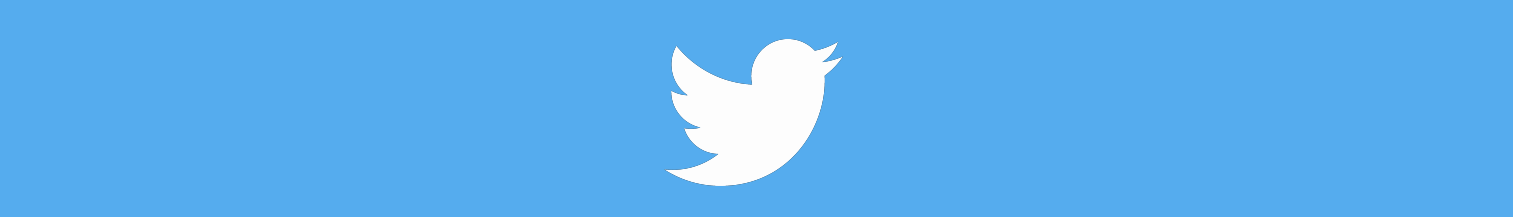

# Natural Language Processing with Disaster Tweets

## Overview

This Notebook will be completed in two main ways.<br/>
First, find and visualize useful data or meaningful relationships within the data.<br/>
Second, select a model based on the visualization of the previous process. Transform or refine the data into the appropriate form for the model to be used.<br/><br/>

This competition is about predicting positive and negative through data.<br/>
That is why we need to go through a careful data preprocessing process.

#### My opinion :
To provide a variety of information to the deep learning model, we will combine the columns 'keyword', 'location' and 'text' of the data.

***

## My workflow
#### 1. Import & Install libray
* Import basic & Enginnering libray
* Install pyspellchecker / stopwords list

#### 2. Check out my data
* Check Shape / Info

#### 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Plot the target data percent
* Plot the Keyword per Count
* Number of alphabets by sentence / Number of words by sentence

#### 4. Prepocessing Data
* Null value processing

#### 5. Feature Enginnering 
* Text data to nomalization
* Use SpellChecker libray
* Plot WordClouds
* Drop unuseful columns
* Text data tokenization
* Text data to fit on Glove Embedding

#### 6. Modeling
* Glove & LSTM Modeling
* Training
* Plot model's loss / accuray values

#### 7. Submission
* Submit the predictions

# 1. Import & Install libray
* Import basic & Enginnering libray
* Install pyspellchecker / stopwords list

In [ ]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import numpy as np
import pandas as pd
import os 
import re

from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer


from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

print("Tensorflow Version",tf.__version__)

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

In [ ]:
!pip install pyspellchecker
from spellchecker import SpellChecker

In [ ]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df.head()

# 2. Check out my data
* Check Shape / Info

In [ ]:
print("Train data size : {}".format(df.shape))

In [ ]:
df.info()

In [ ]:
YlGnBu_palette = sns.color_palette("YlGnBu", 10)
sns.palplot(YlGnBu_palette)

#### ✔️ This notebook will use this palettes.

# 3. Exploratory Data Analysis(EDA) with Visualization [Before Preprocessing]
* Plot the target data percent
* Plot the Keyword per Count
* Number of alphabets by sentence / Number of words by sentence

### 3-1) Plot the target data percent

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
df['target'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True, colors=[YlGnBu_palette[2],YlGnBu_palette[3]])
ax[0].set_title('Pie plot - target')
sns.countplot('target', data=df, ax=ax[1], palette=[YlGnBu_palette[5],YlGnBu_palette[6]])
ax[1].patch.set_alpha(0)
ax[1].set_title('Count plot - target')

fig.text(0.13,0.95,"Plot the target data percent", fontweight="bold", fontfamily='serif', fontsize=20)
plt.show()
#target == 0 : negative(fake)
#tarege == 1 : postive(real)

### 3-2) Plot the Keyword per Count

In [ ]:
keyword_unique = df['keyword'].unique()
print(keyword_unique[:20])

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(16,6))
sns.countplot('keyword',data=df,ax=ax,order=df['keyword'].value_counts().index, palette=sns.color_palette("YlGnBu", 15))
ax.set_xlim(0,15)
ax.patch.set_alpha(0)
fig.text(0.13,0.92,"Count distribution by keyword in Tweets", fontweight="bold", fontfamily='serif', fontsize=20)
plt.show()

### 3-3) Number of alphabets by sentence / Number of words by sentence

In [ ]:
def get_length(text):
    return len(text)

In [ ]:
df['length'] = df['text'].apply(get_length)

In [ ]:
YlGnBu_palette

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(18,5))
plt.hist(df[df['target'] == 0]['length'], alpha = 0.4, bins=150, label = 'Not', color=YlGnBu_palette[3])
plt.hist(df[df['target'] == 1]['length'], alpha = 0.4, bins=150, label = 'Real', color=YlGnBu_palette[6])
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
ax.set_ylabel('')
ax.patch.set_alpha(0)
fig.text(0.13,0.8,"Count distribution by length in Tweets", fontweight="bold", fontfamily='serif', fontsize=25)
plt.show()

# 4. Prepocessing Data
* Null value processing

In [ ]:
df.isnull().sum()

In [ ]:
df['keyword'].fillna("", inplace = True)
df['location'].fillna("",inplace = True)
df.isnull().sum()

# 5. Feature Enginnering 
* Text data to nomalization
* Use SpellChecker libray
* Plot WordClouds
* Drop unuseful columns
* Text data tokenization
* Text data to fit on Glove Embedding

### 5-1) Text data to nomalization

In [ ]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess(text,stem=False):
    text = text.lower()  # lowercase

    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r"'", "", text)
    text = re.sub('\s+', ' ', text).strip()  # Remove and double spaces
    text = re.sub(r'&amp;?', r'and', text)  # replace & -> and
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)  # Remove URLs
    # remove some puncts (except . ! # ?)
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'EMOJI', text)
    
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(SnowballStemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

### 5-2) Use SpellChecker libray

In [ ]:
spell = SpellChecker()
def correct_spell(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [ ]:
text = "corect"
correct_spell(text)

In [ ]:
df.text = df.text.apply(lambda x: preprocess(x))
#df.text = df.text.apply(lambda x: correct_spell(x))

### 5-3) Plot Word Cloud
* fake target
* real target

In [ ]:
mask_dir = np.array(Image.open('../input/masksforwordclouds/twitter_mask3.jpg'))

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(18,9))
target_list = np.unique(df['target'])

for i, target in zip(range(2), target_list):
    wc = WordCloud(background_color="white", max_words = 2000, width = 1600, height = 800, mask=mask_dir, colormap="Blues").generate(" ".join(df[df['target']==target]['text']))
    
    if target == 0:
        axes[i].text(0.5,1, "Fake text", fontweight="bold", fontfamily='serif', fontsize=17)
    else:
        axes[i].text(0.5,1, "Reak text", fontweight="bold", fontfamily='serif', fontsize=17)
    axes[i].patch.set_alpha(0)
    axes[i].axis('off')
    axes[i].imshow(wc)

fig.text(0.1, 0.9,"WordCloud by target per text in Tweets", fontweight="bold", fontfamily='serif', fontsize=22)
plt.show()

### 5-4) Drop unuseful columns

In [ ]:
df.head(10)

In [ ]:
df.drop(['keyword','id','location','length'],axis=1,inplace=True)
df.head(10)

### 5-5) Text data tokenization

In [ ]:
train_data, test_data = train_test_split(df,test_size = 0.2)
print("Train Data size : ",len(train_data))
print("Test Data size : ",len(test_data))

In [ ]:
train_data.head(10)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocab size : ",vocab_size)

### 5-6) Text data to fit on Glove Embedding

In [ ]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen = 30)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen = 30)


print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

In [ ]:
y_train = train_data.target
y_test = test_data.target

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(y_train,y_test)

In [ ]:
GLOVE_EMB = '/kaggle/input/glove6b/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 512

In [ ]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

In [ ]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],                                            
                                            input_length=30,
                                           trainable=False)

# 6. Modeling
* Glove & LSTM Modeling
* Training
* Plot model's loss / accuray values

### 6-1) Glove & LSTM Modeling

In [ ]:
inputs = Input(shape=(30,),dtype = 'int32')

embedding = embedding_layer(inputs)
net = SpatialDropout1D(0.2)(embedding)
net = Bidirectional(LSTM(64,dropout=0.2, recurrent_dropout=0.2))(net)
net = Dense(1,activation = 'sigmoid')(net)

outputs = net
model = tf.keras.Model(inputs,outputs)

In [ ]:
model.compile(optimizer = Adam(learning_rate = LR),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [ ]:
callback = ReduceLROnPlateau(factor=0.1,
                    min_lr = 0.01,
                    monitor = 'val_loss',
                    verbose = 1)

### 6-2) Training

In [ ]:
history = model.fit(x_train,
                    y_train,
                    batch_size=512,
                    epochs=10,
                    validation_data=(x_test, y_test),
                    callbacks = [callback])

### 6-3) Plot model's loss / accuray values

In [ ]:

f,ax = plt.subplots(2,1,figsize=(20,15))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['LSTM_train', 'LSTM_val'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train', 'val'], loc = 'upper left')

f.tight_layout()
plt.show()

# 7. Submission
* Submit the predictions

In [ ]:
sample = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

In [ ]:
sample.head()

In [ ]:
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [ ]:
test.head()

In [ ]:
test.drop(['keyword','id','location',],axis=1,inplace=True)
test.head(10)

In [ ]:
test.text = test.text.apply(lambda x: preprocess(x))

In [ ]:
test.shape

In [ ]:
test = pad_sequences(tokenizer.texts_to_sequences(test.text), maxlen = 30)

print("test Shape:",test.shape)

In [ ]:
prediction = model.predict(test)
prediction = list(1 if x>0.5 else 0 for x in list(prediction))
prediction[:10]

In [ ]:
sample['target'] = prediction
sample['target'].value_counts()

In [ ]:
sample.to_csv('submission.csv',index=False)

##### reference 
* https://www.kaggle.com/mnavaidd/tweet-classification-using-lstm-bert/notebook?select=glove.6B.zip
* https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

###  If this notebook is useful for your kaggling, "UPVOTE" for it 👀
#### THX to Reading My Notebook🌈